<a id="top"></a>
# Long Period TESS Targets with Kepler Counterparts: Solutions
***

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

#from astropy.io import fits # JRK CHECK IF NOT USED
from astropy.table import Table
from astroquery.mast import Observations

import lightkurve as lk
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.time import Time

## Exercise 1
Go to the [Data page of the NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/docs/data.html) and download the TCE table with all columns and all rows. Load it here and confirm that it matches the .csv file included with the tutorial. Then, sort your new table to include only Non-Transiting Phenomena with periods of less than or equal to 180 days. 

In [2]:
# First, we need to load the original table from the notebook. Then we will proceed with the solution.
tab=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#') 
tab
# Your filename will vary depending on when you downloaded the .csv file. 
# Presuming your filename is filename.csv, the correct command to load it as a (new) table could be:
# tab2=Table.read('filename.csv',format='ascii.csv',comment='#') 
# By naming the table "tab2" we do not overwrite the previous variable "tab"
# For the purpose of the solution, we'll use the same file.
tab2=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#') 
tab2
# This is just one way to test of the two tables are equivalent; you may have another method.
# tab==tab2 returns an boolean array with "True" for every row in the table that are equivalent. 
# The sum of the array, if all elements are "True", will equal the length of the table.
print(np.sum(tab==tab2))
print(len(tab))
# Finally, now we want to narrow down the table to include only Non-Transiting Phenomena with periods less than 
# or equal to 180 days
tab2=tab2[tab2['av_pred_class']=='NTP']
print('Non-Transiting Phenomena',len(tab2))
tab2=tab2[tab2['tce_period']<=180]
print('NTP with periods less than or equal to 180 days',len(tab2))
# 5075 TCEs match the criteria.

20367
20367
Non-Transiting Phenomena 6203
NTP with periods less than or equal to 180 days 5075


## Exercise 2
One of the target names listed above, '137685450', turns out to be the TESS Input Catalog (TIC) identifier for this target. Search the MAST archive by this object name, with the same search radius of 1 arcsecond, and confirm that the two result tables are identical. Do you need to add 'TIC' and input the number as string like we did above, or can you just use the number alone?

In [3]:
# First, we need to load the observation results table from the notebook. Then we will proceed with the solution.
obs_table = Observations.query_object('KIC 2581316',radius=1*u.arcsec)
# Search by TIC ID instead
obs_table2=Observations.query_object('TIC 137685450',radius=1*u.arcsec)
# Note that you DO need to include "TIC"; trying to just use 137685450 as either a string or integer input
# will result in "ResolverError: Could not resolve 137685450 to a sky position."
# We can check that the two tables have the same length and contain the same unique list of target names. 
print(len(obs_table2))
print(np.unique(obs_table2['target_name']))

89
     target_name      
----------------------
             137685450
              2144.049
Kepler10-1-2-1-1-1-1-1
                    --
              TESS FFI
              TICA FFI
         kplr002581316


## Exercise 3

In [4]:
# The table 'tab' was already loaded into this solutions notebook in Exercise 1, but
# needs to be narrowed down to our 55 candidates, by reproducing steps already
# done in the original notebook.
tab=tab['kepid','tce_period','tce_period_err','tce_time0bk','tce_time0bk_err','tce_depth','tce_duration','av_pred_class']
tab=tab[tab['av_pred_class']=='PC']
tab=tab[tab['tce_period']>180]
# This is the array of those that ended up having TESS observations
haveTESS=[ True,  True, False, False, False, False,  True, False, False,
       False,  True, False,  True,  True, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
        True,  True, False,  True, False,  True, False,  True,  True,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
       False, False,  True, False, False,  True,  True, False,  True,
        True, False, False, False, False, False,  True,  True, False,
        True,  True, False,  True, False,  True, False, False,  True,
        True, False, False, False,  True, False]
tab=tab[haveTESS]

In [5]:
# Create a new column to hold the number of Kepler lightcurves available (of any cadence)
n=len(tab)
tab.add_column(np.zeros(n,dtype=int),name='nKepler')
# Based on the results from Exercise 2 (obs_table2), above, Kepler 
# lightcurves will be listed with project=Kepler, obs_collection='HLSP',
# and target name (at least for those lightcurves with Provenance Name = KEPSEISMIC) 
# will be e.g. kplr002581316, or 'kplr' plus the id number with leading zeros to make 9 digits total.
# We may be missing other high-level science products by limiting by this target name,
# so an alternative is to use a cone search with 
# objectname='KIC '+str(row['kepid']),radius=1*u.arcsec
# but that will take longer.
# Do not include the t_exptime limits.
for i,row in enumerate(tab):
    #print('kplr'+f"{row['kepid']:09d}")
    obs_count = Observations.query_criteria_count(target_name='kplr'+f"{row['kepid']:09d}",
                                        project='Kepler',obs_collection='HLSP',
                                        dataproduct_type='timeseries')
    tab['nKepler'][i]=obs_count

## Exercise 4
a. For the first target in the table (row 0), find the year, month, and day (in UTC) of all predicted transits from 2018 until today. Use propagation of error (and the formula presented to you above, $\sqrt{\sigma_{t_0}^2+(n \sigma_p)^2}$) to determine the error on the predicted transits. Is the error on the order of minutes, days, or weeks?  
b. We chose to only calculate the next 30 predicted transit times. Given the approximate mission dates of Kepler and the limits we placed on the predicted period, show that this is an adequate number of transit times.

In [6]:
# At this point, load the final table so we don't have to recreate 
# the analysis of the timed searching.
tab=Table.read('final_table.csv')

In [7]:
# Solution for part a.
row=tab[0]
# The first part can be accomplished using the same code as in the loop, and then printing the result with the formatting of "ymd" for year month day.
# Possible date/times of central transits, offset.
t_n=row['tce_time0bk']+row['tce_period']*np.arange(30)
# Convert this array of floats to one of DateTime objects, in Barycentric Julian Days
t_n=Time(t_n+2454833.0,format='jd')
# Only test those from 2018-today's date
t_n=t_n[t_n.ymdhms.year>=2018]
t_n=t_n[t_n<=Time.now()]
# Print the remaining t_n values in a format from which we can easily see year, month, day.
print([x.ymdhms for x in t_n])
# Propagate error.
t_n_err=np.sqrt(row['tce_time0bk_err']**2 + (np.arange(30)*row['tce_period_err'])**2)
# Print the errors. Note that the units of all the quantities above were in days, so is our final result.
print(t_n_err)
# The errors are small. Multiply by the number of minutes in a day, 24*60.
print(t_n_err*24.0*60.0)
# The errors are on the order of minutes.

[(2018, 1, 2, 23, 13, 55.19998938), (2018, 8, 8, 19, 11, 59.99998391), (2019, 3, 14, 15, 10, 4.80001867), (2019, 10, 18, 11, 8, 9.6000132), (2020, 5, 23, 7, 6, 14.40000773), (2020, 12, 27, 3, 4, 19.20000225), (2021, 8, 1, 23, 2, 23.99999678), (2022, 3, 7, 19, 0, 28.79999131), (2022, 10, 11, 14, 58, 33.59998584), (2023, 5, 17, 10, 56, 38.39998037)]
[0.00028531 0.00029555 0.00032434 0.00036734 0.00042021 0.0004797
 0.00054364 0.00061063 0.00067977 0.00075048 0.00082233 0.00089507
 0.00096848 0.00104243 0.00111681 0.00119154 0.00126656 0.00134181
 0.00141727 0.0014929  0.00156867 0.00164457 0.00172058 0.00179668
 0.00187287 0.00194913 0.00202546 0.00210184 0.00217828 0.00225476]
[0.41084352 0.42559    0.46704411 0.52896357 0.60509803 0.69076312
 0.78283629 0.87930684 0.97887553 1.08068634 1.18416112 1.28889916
 1.39461587 1.5011045  1.60821171 1.71582167 1.82384539 1.93221347
 2.04087106 2.14977427 2.25888756 2.3681819  2.47763334 2.58722192
 2.69693094 2.80674627 2.9166559  3.02664956 3.

In [8]:
# Solution for part b.
# The original Kepler mission started observing in April 2009. 
# We have chosen to only study those TCEs with periods of > 180 days, or 6 months. 
# 30 times 6 months = 180 months, or 15 years.
# 15 years after April 2009 would be April 2024.
# Most planets will have first transit times *after* April 2009 and 
# have periods greater than 180 days, so 30 transits will be 
# more than enough to cover all time periods from the start
# of the TESS mission until April 2024. 

## Exercise 5
Choose the next target from our table (KIC 4820550) and download and plot a TESS lightcurve that likely contains one of the predicted transits. Confirm that the lightcurve contains the predicted transit time. Is the transit as clearly visible as our example above? Optional: Make an estimate of the amount of scatter in the light curve and compare it to the predicted transit depth. How does this explain whether or not you can see the transit?

INFO: Found cached file ./mastDownload/HLSP/hlsp_qlp_tess_ffi_s0054-0000000121013026_tess_v01_llc/hlsp_qlp_tess_ffi_s0054-0000000121013026_tess_v01_llc.fits with expected size 213120. [astroquery.query]


(0.95, 1.05)

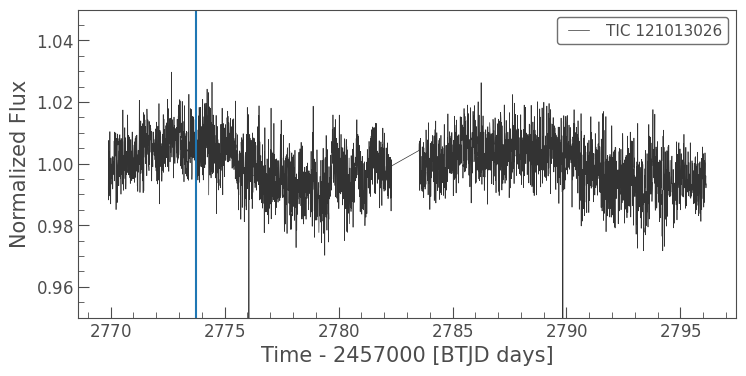

In [9]:
# Select the 2nd row of the table.
i=1
row=tab[i]
# From here on out, much of the code is the same.
time=Time(row['t_n MJD 1'],format='mjd')
obs_table = Observations.query_criteria(target_name=row['TIC'],
                                              project='TESS',obs_collection='HLSP',
                                              dataproduct_type='timeseries',
                                              t_exptime=[20.0,600.0],
                                              t_min=[time.value-27,time.value-1],
                                              t_max=[time.value+1,time.value+27])
# Only one observation is returned.
data_prod = Observations.get_product_list(obs_table)
data_prod
# In this case, only one data product is associated with this observation.
manifest=Observations.download_products(data_prod)
lc=lk.read(manifest['Local Path'][0])
lc.plot()
plt.axvline(time.jd-2457000)
# The vertical line does indeed show up in our dataset, but the transit itself is not (easily)
# visible in the dataset. Be careful not to read too much into 
# individual dips in the plot; these are unlikely to be transits.
plt.ylim([0.95,1.05]) # This helps us focus on the good data, not outliers.

In [10]:
# Optional
# One way to estimate the scatter is to examine median relative error, or the ratio of the error to the flux.
print('Median relative error: ',np.median(np.median(lc.flux_err/lc.flux)))
# Compare that to the predicted depth, which was reported in parts per million
print(row['tce_depth']*1e-6)
# The median error is larger than the transit depth; TESS is not as sensitive as Kepler 
# to 

Median relative error:  0.006804158445447683
0.002742


## Additional Exercises

### Exercise 6
Investigating Planetary Candidates: Use the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) to examine the 14 Kepler TCE Planetary Candidates in our most refined table. Which ones have since been confirmed as exoplanets? Which ones remain Planetary Candidates?

In [11]:
# It's possible to search the NASA Exoplanet Archive by KIC number individually, or
# to load a version of our final_table.csv file with the coordinates and/or object names (preceeded by 'KIC')
# The results page looks as follows, and shows us that 7 of the 14 KIC objects have confirmed exoplanets.

### Exercise 7

Alternative search priorities: In the beginning of this tutorial, we focused on planetary candidates with long periods (> 6 months). Alternatively, you could choose to focus your search on planetary candidates with the largest transit depth, irrespective of period. You could also choose to investigate possible astrophysical false positives instead of planetary candidates. Design your own search procedure to use TESS spectra to learn more about Kepler TCE's. Justify the choices you are making; how are you narrowing down your target list, and why? What criteria will you use to determine which TESS spectra are applicable? Plot at least one spectrum that meets your criteria.

In [12]:
# There are many possible solutions to this exercise,
# that would follow the same general procedure as that in the section titled
# "Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period"